### Imports:

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.stats import mannwhitneyu
import pandas as pd

from network.visulization import parse_log_files, plot_3d_removal_network, plot_3d_graph
from network.network import dynamic_network_model, debris_removal_network

### Plots For Launching Satellites

Below, the plots for the added feature of launching satellites are generated. Change the num_simulations variable to a lower number if you want to run the simulation fewer times. Otherwise, running all simulations might take a while.

Running simulations WITHOUT satellite launches...
In time step 0, 0 new satellites were launched, total nodes = 1003 

In time step 5, 0 new satellites were launched, total nodes = 1042 

In time step 10, 0 new satellites were launched, total nodes = 1085 

In time step 15, 0 new satellites were launched, total nodes = 1123 

In time step 20, 0 new satellites were launched, total nodes = 1184 

In time step 25, 0 new satellites were launched, total nodes = 1244 

In time step 30, 0 new satellites were launched, total nodes = 1317 

In time step 35, 0 new satellites were launched, total nodes = 1400 

In time step 40, 0 new satellites were launched, total nodes = 1478 

In time step 45, 0 new satellites were launched, total nodes = 1572 

In time step 50, 0 new satellites were launched, total nodes = 1703 

In time step 55, 0 new satellites were launched, total nodes = 1826 

In time step 60, 0 new satellites were launched, total nodes = 1945 

In time step 65, 0 new satellites were lau

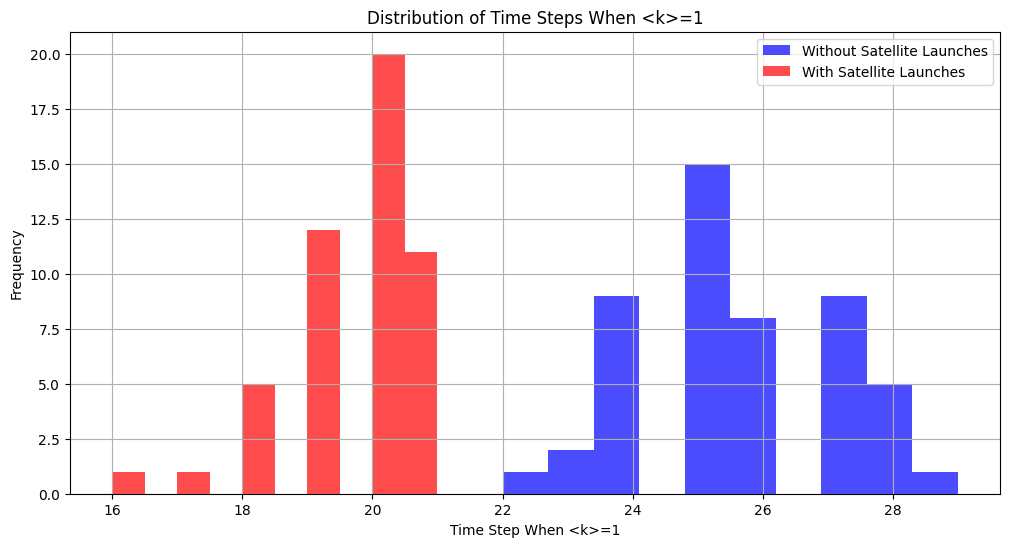

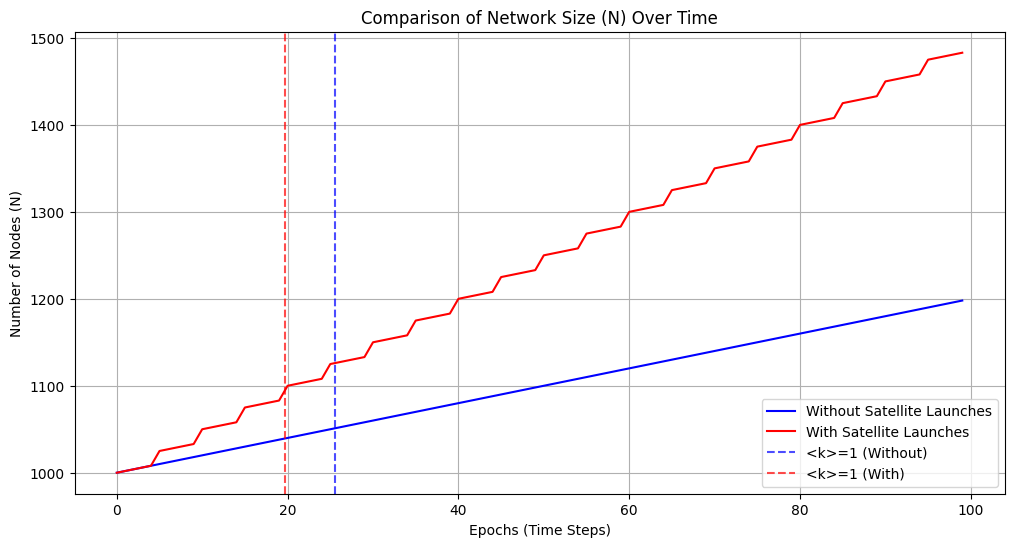

/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_43214/2406186153.py:104: RuntimeWarning: Mean of empty slice
  plt.plot(range(iterations), np.nanmean(gc_proportions_without_all, axis=0), label="Without Satellite Launches", color="blue")
/var/folders/sq/c9xq2zk97n3cf_nqf5x49c0w0000gn/T/ipykernel_43214/2406186153.py:105: RuntimeWarning: Mean of empty slice
  plt.plot(range(iterations), np.nanmean(gc_proportions_with_all, axis=0), label="With Satellite Launches", color="red")


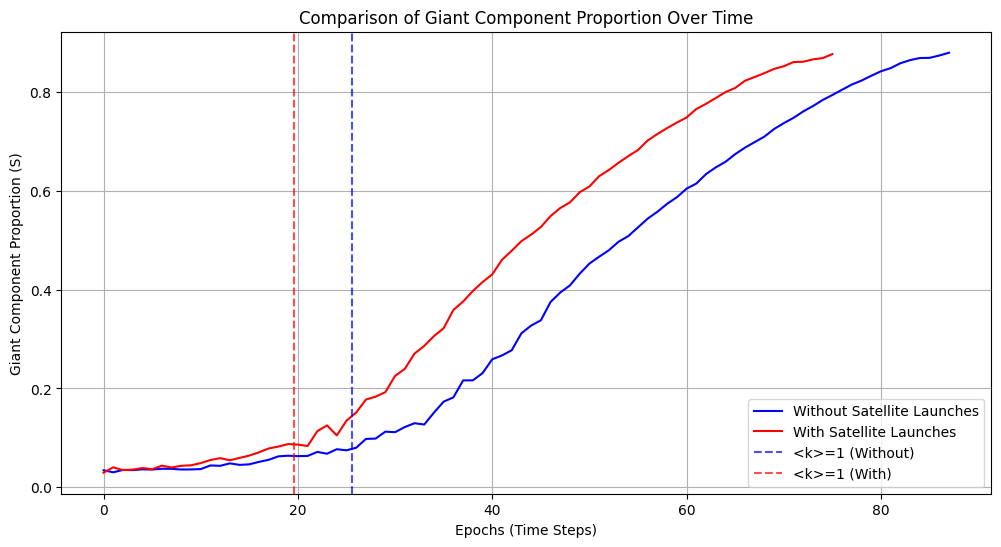

In [21]:
# Parameters
N = 1000  # Initial number of nodes
P = 0.0008  # Collision probability
plow = 0.01  # Probability of generating new fragments
new_fragments_per_collision = 2  # Debris per collision
iterations = 100  # Number of time steps
launch_freq = 5  # Launch satellites every 5 time steps
nr_sat_launches = 15  # Number of satellites launched per launch
num_simulations = 50  # Number of simulations to average

# Initialize arrays to store results across simulations
nodes_over_time_without_all = []
nodes_over_time_with_all = []
avg_degrees_without_all = []
avg_degrees_with_all = []
gc_proportions_without_all = []
gc_proportions_with_all = []
k_equal_1_timesteps_without = []
k_equal_1_timesteps_with = []

# Run simulations without satellite launches
print("Running simulations WITHOUT satellite launches...")
for _ in range(num_simulations):
    G_without_sat = nx.empty_graph(N)
    avg_degrees_without, gc_proportions_without, _ = dynamic_network_model(
        G_without_sat, iterations, P, plow, new_fragments_per_collision, nr_sat_launches=0, launch_freq=launch_freq
    )
    avg_degrees_without_all.append(np.pad(avg_degrees_without, (0, iterations - len(avg_degrees_without)), constant_values=np.nan))
    gc_proportions_without_all.append(np.pad(gc_proportions_without, (0, iterations - len(gc_proportions_without)), constant_values=np.nan))
    nodes_over_time_without = [N + i * new_fragments_per_collision for i in range(iterations)]
    nodes_over_time_without_all.append(nodes_over_time_without)
    
    k_equal_1_timestep = next((i for i, k in enumerate(avg_degrees_without) if k >= 1), None)
    if k_equal_1_timestep is not None:
        k_equal_1_timesteps_without.append(k_equal_1_timestep)

# Run simulations with satellite launches
print("Running simulations WITH satellite launches...")
for _ in range(num_simulations):
    G_with_sat = nx.empty_graph(N)
    avg_degrees_with, gc_proportions_with, _ = dynamic_network_model(
        G_with_sat, iterations, P, plow, new_fragments_per_collision, nr_sat_launches, launch_freq
    )
    avg_degrees_with_all.append(np.pad(avg_degrees_with, (0, iterations - len(avg_degrees_with)), constant_values=np.nan))
    gc_proportions_with_all.append(np.pad(gc_proportions_with, (0, iterations - len(gc_proportions_with)), constant_values=np.nan))
    nodes_over_time_with = [
        N + i * new_fragments_per_collision + (i // launch_freq) * nr_sat_launches for i in range(iterations)
    ]
    nodes_over_time_with_all.append(nodes_over_time_with)
    
    k_equal_1_timestep = next((i for i, k in enumerate(avg_degrees_with) if k >= 1), None)
    if k_equal_1_timestep is not None:
        k_equal_1_timesteps_with.append(k_equal_1_timestep)

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(k_equal_1_timesteps_without, k_equal_1_timesteps_with, alternative='greater')

print("Mann-Whitney U Test Results:")
print(f"U Statistic: {stat}")
print(f"P-Value: {p_value}")

# Compute U statistic range
n1, n2 = len(k_equal_1_timesteps_without), len(k_equal_1_timesteps_with)
U_min, U_max = 0, n1 * n2
print(f"U Statistic Range: {U_min} to {U_max}")

# Plot statistical frequency distribution
plt.figure(figsize=(12, 6))
plt.hist(k_equal_1_timesteps_without, alpha=0.7, label="Without Satellite Launches", color="blue", bins=10)
plt.hist(k_equal_1_timesteps_with, alpha=0.7, label="With Satellite Launches", color="red", bins=10)
plt.xlabel("Time Step When <k>=1")
plt.ylabel("Frequency")
plt.title("Distribution of Time Steps When <k>=1")
plt.legend()
plt.grid(True)
plt.show()

# Plot the results for network size over time
plt.figure(figsize=(12, 6))
plt.plot(range(iterations), np.nanmean(nodes_over_time_without_all, axis=0), label="Without Satellite Launches", color="blue")
plt.plot(range(iterations), np.nanmean(nodes_over_time_with_all, axis=0), label="With Satellite Launches", color="red")

# Add horizontal lines for <k>=1 timesteps
if k_equal_1_timesteps_without:
    plt.axvline(x=np.mean(k_equal_1_timesteps_without), color="blue", linestyle="--", alpha=0.7, label="<k>=1 (Without)")
if k_equal_1_timesteps_with:
    plt.axvline(x=np.mean(k_equal_1_timesteps_with), color="red", linestyle="--", alpha=0.7, label="<k>=1 (With)")

plt.xlabel("Epochs (Time Steps)")
plt.ylabel("Number of Nodes (N)")
plt.title("Comparison of Network Size (N) Over Time")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot the results for giant component proportion over time
plt.figure(figsize=(12, 6))
plt.plot(range(iterations), np.nanmean(gc_proportions_without_all, axis=0), label="Without Satellite Launches", color="blue")
plt.plot(range(iterations), np.nanmean(gc_proportions_with_all, axis=0), label="With Satellite Launches", color="red")

# Add horizontal lines for <k>=1 timesteps
if k_equal_1_timesteps_without:
    plt.axvline(x=np.mean(k_equal_1_timesteps_without), color="blue", linestyle="--", alpha=0.7, label="<k>=1 (Without)")
if k_equal_1_timesteps_with:
    plt.axvline(x=np.mean(k_equal_1_timesteps_with), color="red", linestyle="--", alpha=0.7, label="<k>=1 (With)")

plt.xlabel("Epochs (Time Steps)")
plt.ylabel("Giant Component Proportion (S)")
plt.title("Comparison of Giant Component Proportion Over Time")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [4]:
# initial parameters
N = 1000  # nodes
P = 0.0008  # collision probability
plow = 0.01 # probability of generating new fragments
new_fragments_per_collision = 2  # debris per collision 
iterations = 2000  # number of iterations, time steps
P0 = 0.0003
rate = N**2 * P0 * plow
alpha_list = np.linspace(0, 14, 7)


for alpha in alpha_list:
    G = nx.empty_graph(N)
debris_removal_network(G, iterations, P0, plow, new_fragments_per_collision, int(15) * int(rate))

New fragment 968 generated from collision between 788 and 392, total nodes = 969 

New fragment 969 generated from collision between 905 and 841, total nodes = 969 

New fragment 969 generated from collision between 785 and 113, total nodes = 969 

New fragment 972 generated from collision between 819 and 458, total nodes = 973 

New fragment 973 generated from collision between 885 and 104, total nodes = 974 

New fragment 974 generated from collision between 864 and 134, total nodes = 975 

New fragment 975 generated from collision between 949 and 110, total nodes = 976 

New fragment 976 generated from collision between 774 and 665, total nodes = 977 

New fragment 977 generated from collision between 774 and 665, total nodes = 978 

New fragment 978 generated from collision between 902 and 274, total nodes = 979 

New fragment 979 generated from collision between 495 and 347, total nodes = 980 

New fragment 980 generated from collision between 784 and 49, total nodes = 981 

New f

### Plots for Debris Removal

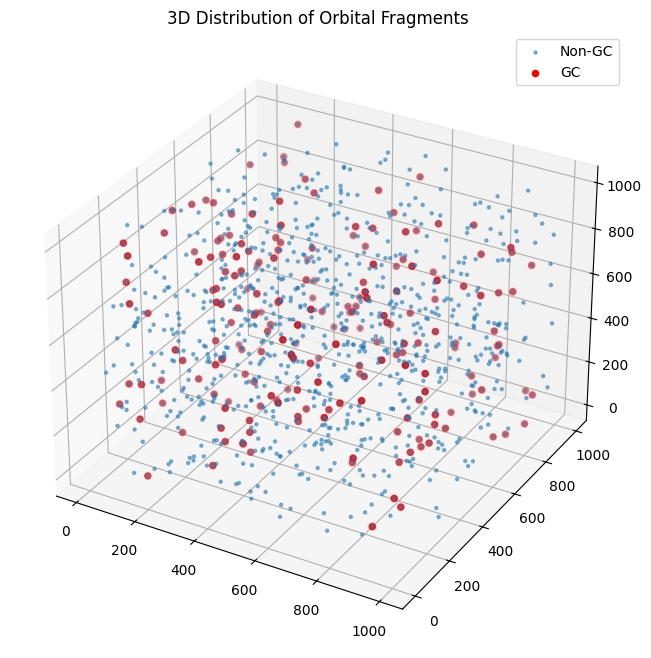

In [7]:
# random 3D positions
N = 1000
positions = np.random.rand(N, 3) * 1000

# randomly select 200 positions as GC
gc_indices = np.random.choice(N, size=200, replace=False)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=5, alpha=0.5, label="Non-GC")
ax.scatter(positions[gc_indices, 0], positions[gc_indices, 1], positions[gc_indices, 2],
           s=20, color='red', label="GC")
plt.legend()
plt.title("3D Distribution of Orbital Fragments")
plt.show()

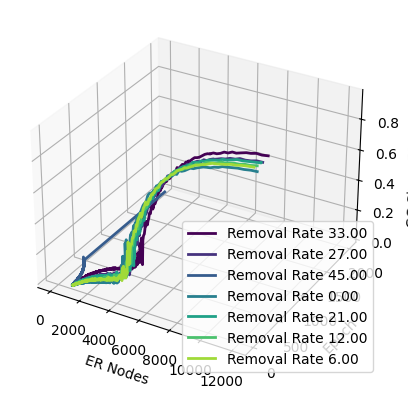

In [1]:
folder_path = "../results"

# data = parse_log_files(folder_path)
# # sort the data by initial probability
# data.sort(key=lambda x: x[0])
# plot_3d_graph(data)

data = parse_log_files(folder_path, "removal_debris_")
plot_3d_removal_network(data)

 Initial probability = 0.00010891, GC2 ER network Size = 3, Avg Degree = 0.12
Initial probability = 0.00011078, GC2 ER network Size = 3, Avg Degree = 0.09
Initial probability = 0.00011861, GC2 ER network Size = 3, Avg Degree = 0.11
Initial probability = 0.00013141, GC2 ER network Size = 3, Avg Degree = 0.15
Initial probability = 0.00017566, GC2 ER network Size = 4, Avg Degree = 0.16
Initial probability = 0.00016129, GC2 ER network Size = 4, Avg Degree = 0.18
Initial probability = 0.00019796, GC2 ER network Size = 5, Avg Degree = 0.20
Initial probability = 0.00024298, GC2 ER network Size = 5, Avg Degree = 0.24
Initial probability = 0.00031930, GC2 ER network Size = 5, Avg Degree = 0.33
Initial probability = 0.00041250, GC2 ER network Size = 5, Avg Degree = 0.39
Initial probability = 0.00051501, GC2 ER network Size = 7, Avg Degree = 0.46
Initial probability = 0.00055142, GC2 ER network Size = 12, Avg Degree = 0.59
Initial probability = 0.0006214, GC2 ER network Size = 17, Avg Degree = 0.

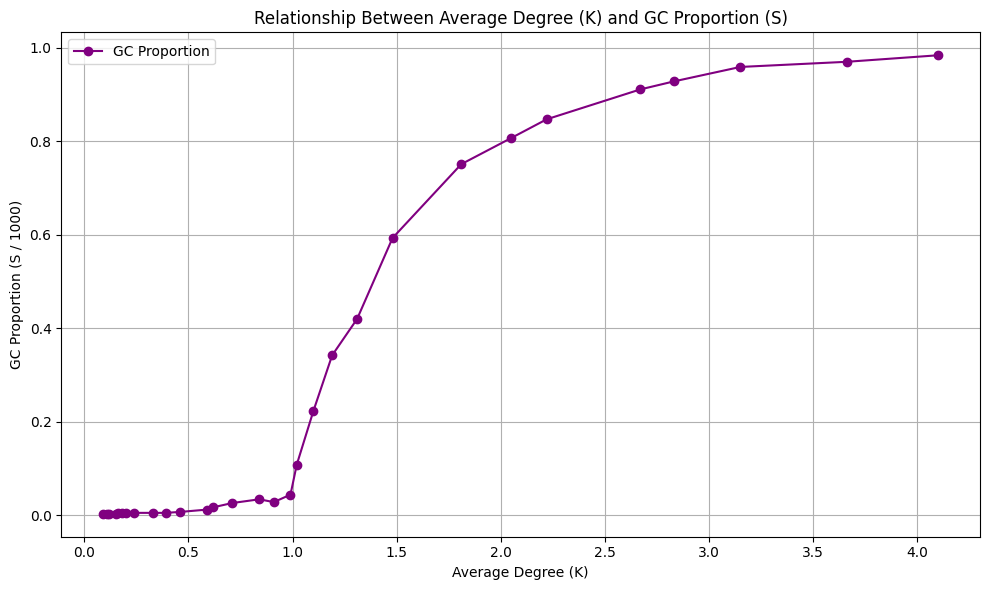

In [12]:
# Data parsing
data = """ Initial probability = 0.00010891, GC2 ER network Size = 3, Avg Degree = 0.12
Initial probability = 0.00011078, GC2 ER network Size = 3, Avg Degree = 0.09
Initial probability = 0.00011861, GC2 ER network Size = 3, Avg Degree = 0.11
Initial probability = 0.00013141, GC2 ER network Size = 3, Avg Degree = 0.15
Initial probability = 0.00017566, GC2 ER network Size = 4, Avg Degree = 0.16
Initial probability = 0.00016129, GC2 ER network Size = 4, Avg Degree = 0.18
Initial probability = 0.00019796, GC2 ER network Size = 5, Avg Degree = 0.20
Initial probability = 0.00024298, GC2 ER network Size = 5, Avg Degree = 0.24
Initial probability = 0.00031930, GC2 ER network Size = 5, Avg Degree = 0.33
Initial probability = 0.00041250, GC2 ER network Size = 5, Avg Degree = 0.39
Initial probability = 0.00051501, GC2 ER network Size = 7, Avg Degree = 0.46
Initial probability = 0.00055142, GC2 ER network Size = 12, Avg Degree = 0.59
Initial probability = 0.0006214, GC2 ER network Size = 17, Avg Degree = 0.62
Initial probability = 0.00073711, GC2 ER network Size = 26, Avg Degree = 0.71
Initial probability = 0.00078921, GC2 ER network Size = 34, Avg Degree = 0.84
Initial probability = 0.00092029, GC2 ER network Size = 28, Avg Degree = 0.91
Initial probability = 0.00096866, GC2 ER network Size = 44, Avg Degree = 0.99
Initial probability = 0.00105498, GC2 ER network Size = 108, Avg Degree = 1.02
Initial probability = 0.00103712, GC2 ER network Size = 223, Avg Degree = 1.10
Initial probability = 0.00125139, GC2 ER network Size = 342, Avg Degree = 1.19
Initial probability = 0.00136291, GC2 ER network Size = 420, Avg Degree = 1.31
Initial probability = 0.00153593, GC2 ER network Size = 593, Avg Degree = 1.48
Initial probability = 0.00182188, GC2 ER network Size = 751, Avg Degree = 1.81
Initial probability = 0.00185325, GC2 ER network Size = 807, Avg Degree = 2.05
Initial probability = 0.00223614, GC2 ER network Size = 847, Avg Degree = 2.22
Initial probability = 0.00256340, GC2 ER network Size = 911, Avg Degree = 2.67
Initial probability = 0.00279184, GC2 ER network Size = 928, Avg Degree = 2.83
Initial probability = 0.00314626, GC2 ER network Size = 959, Avg Degree = 3.15
Initial probability = 0.00366884, GC2 ER network Size = 970, Avg Degree = 3.66
Initial probability = 0.00406460, GC2 ER network Size = 984, Avg Degree = 4.10
"""


rows = []
for line in data.splitlines():
    print(line)
    parts = line.split(", ")
    prob = float(parts[0].split(" = ")[1])
    gc_size = int(parts[1].split(" = ")[1])
    avg_degree = float(parts[2].split(" = ")[1])
    rows.append((prob, gc_size, avg_degree))

df = pd.DataFrame(rows, columns=["Initial Probability", "GC Size", "Avg Degree"])
df["GC Proportion"] = df["GC Size"] / 1000  # Network size fixed at 1000

# Plotting with Average Degree on the x-axis and GC Proportion on the y-axis
plt.figure(figsize=(10, 6))
plt.plot(df["Avg Degree"], df["GC Proportion"], label="GC Proportion", color="purple", marker="o")
plt.xlabel("Average Degree (K)")
plt.ylabel("GC Proportion (S / 1000)")
plt.title("Relationship Between Average Degree (K) and GC Proportion (S)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./plottings/network_k_S_ph.png")
plt.show()

# # GC Proportion vs. Initial Probability
# plt.subplot(2, 1, 2)
# plt.plot(df["Initial Probability"], df["GC Proportion"], label="GC Proportion", color="red")
# plt.xscale("log")
# plt.xlabel("Initial Probability (log scale)")
# plt.ylabel("GC Proportion")
# plt.title("Effect of Link Probability on GC Proportion")
# plt.grid(True)
# plt.legend()

# plt.tight_layout()
# plt.show()


### Plot for example of potential SOC

In [ ]:
x = np.linspace(0, 4, 1200)

def final_wave(x):
    y = np.zeros_like(x)
    for i in range(int(np.ceil(max(x)))):
        mask = (x >= i) & (x < i + 1)
        segment_x = x[mask] - i
        y[mask] = np.where(segment_x < 0.2, 0,
                           np.where(segment_x < 0.7, 5 * (segment_x - 0.2)**2,
                                    0))
    return y

y = final_wave(x)

# Plotting the final refined function
plt.figure(figsize=(10, 5))
plt.plot(x / 4 * 100, y / max(y) * 100)

pastel_red = (1, 0.4, 0.4)

# Adding red dashed vertical lines exactly where the rise starts
rise_starts = np.array([0.2, 1.2, 2.2, 3.2]) 
for start in rise_starts:
    plt.axvline(x=start / 4 * 100, color=pastel_red, linestyle='--')

plt.title('Potential SOC')
plt.xlabel('Time')
plt.ylabel('Collisions')
plt.grid(True)
plt.legend(['System Dynamics', 'Kessler Emergence'])
plt.show()